<a href="https://colab.research.google.com/github/musicjae/NLP/blob/master/seq2seq/character_level_MT_(seq2seq).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving s1.jpeg to s1.jpeg
User uploaded file "s1.jpeg" with length 10510 bytes


In [53]:
from IPython.display import Image

이 코드는 텐서플로우의 seq2seq에서 소개한 것과 유사하다. 아마 이 글의 저자도 이것을 참고하여 카피 및 수정한 것 같다.

In [3]:
import numpy as np
import pandas as pd
import re
import shutil
import os
import unicodedata
import urllib3
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

목표: seq2seq를 이용하여 프랑스어로 이루어진 문장을 영어로 이루어진 문장으로 번역해보자.

# 0. Data Load

In [4]:
http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

샘플 개수 설정

In [5]:
num_samples = 33000 

# 1. 전처리 함수들  
  
자연어 처리 분야는 전처리 과정이 까다로운 것 같다. 이것에 대한 추가적인 공부가 요구되는 것 같다.

## 유니코드 -> 아스키 코드

In [6]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

문장 전처리 하기  
- 단어와 구두점 사이 공백 만들기  


In [7]:
def preprocess_sentence(sent):
    # 위에서 구현한 함수를 내부적으로 호출
    sent = unicode_to_ascii(sent.lower())

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    sent = re.sub(r"\s+", " ", sent)
    return sent

In [8]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"
print(preprocess_sentence(en_sent))
print(preprocess_sentence(fr_sent).encode('utf-8'))

have you had dinner ?
b'avez vous deja dine ?'


- 교사 강요 Teacher Forcing을 사용하기 위해 (1) 디코더의 입력 시퀀스, (2) 디코더의 출력 시퀀스를 따로 분리해 저장하자.  
  
- 문장의 시작 시에는 'sos'를, 종료 시에는 'eos'를 출력한다.

In [9]:
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], [] # 인코더와 디코더 둘을 분리 하기 위해

    with open("fra.txt", "r") as lines: # 프랑스 단어 집합을 연다
        for i, line in enumerate(lines):

            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t') # 탭tab을 기준으로 하여 분리

            # source 데이터 전처리
            src_line_input = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_input = [w for w in ("<sos> " + tar_line).split()]
            tar_line_target = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line_input)
            decoder_input.append(tar_line_input)
            decoder_target.append(tar_line_target)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

우리는 위 코드에서  
- 인코더_입력  
- 디코더_입력  
- 디코더_타겟  
  
이렇게 3 개를 출력했다. 아래에서 이것의 일부를 출력해보자.

In [10]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print(sents_en_in[:5])
print(sents_fra_in[:5])
print(sents_fra_out[:5])

[['go', '.'], ['hi', '.'], ['hi', '.'], ['run', '!'], ['run', '!']]
[['<sos>', 'va', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.'], ['<sos>', 'cours', '!'], ['<sos>', 'courez', '!']]
[['va', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>'], ['cours', '!', '<eos>'], ['courez', '!', '<eos>']]


## 1.2. 토크나이저  
  
- txt를 단어 단위로 쪼개어 단어 집합Vocabulary를 생성한다.  
  
- 그 다음에, text 시퀀스를 integer 시퀀스로 인코딩 한다.

In [11]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
print('samples: ',encoder_input[:5])
print('length:',len(encoder_input))

samples:  [[30, 1], [1132, 1], [1132, 1], [260, 32], [260, 32]]
length: 33000


In [12]:
tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)
decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)

print(decoder_input[:3],len(decoder_input))
print(decoder_target[:3],len(decoder_target))

[[2, 89, 12], [2, 1020, 12], [2, 1020, 1]] 33000
[[89, 12, 3], [1020, 12, 3], [1020, 1, 3]] 33000


## 1.3 패딩Padding 수행  
  
가변 길이의 입력을 고정 길이로 만들어주기 위해 수행

In [13]:
encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_target = pad_sequences(decoder_target, padding="post")

print('인코더 인풋 최대 길이:', len(encoder_input[0]))
print('디코더 입력 최대 길이:',len(decoder_input[0]))
print('디코더 타겟 최대 길이:',len(decoder_target[0]),'\n')

for i in range(3):
    print(i,'th encoder input',encoder_input[i])
    print(i,'th decoder input',decoder_input[i])
    print(i,'th decoder target',decoder_target[i],'\n')




인코더 인풋 최대 길이: 8
디코더 입력 최대 길이: 16
디코더 타겟 최대 길이: 16 

0 th encoder input [30  1  0  0  0  0  0  0]
0 th decoder input [ 2 89 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 th decoder target [89 12  3  0  0  0  0  0  0  0  0  0  0  0  0  0] 

1 th encoder input [1132    1    0    0    0    0    0    0]
1 th decoder input [   2 1020   12    0    0    0    0    0    0    0    0    0    0    0
    0    0]
1 th decoder target [1020   12    3    0    0    0    0    0    0    0    0    0    0    0
    0    0] 

2 th encoder input [1132    1    0    0    0    0    0    0]
2 th decoder input [   2 1020    1    0    0    0    0    0    0    0    0    0    0    0
    0    0]
2 th decoder target [1020    1    3    0    0    0    0    0    0    0    0    0    0    0
    0    0] 



## 1.4 단어 집합 만들기

In [14]:
src_vocab_size = len(tokenizer_en.word_index) + 1 # source vocabulary
tar_vocab_size = len(tokenizer_fra.word_index) + 1 # target v - 
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4663, 프랑스어 단어 집합의 크기 : 8038


## 1.5 딕셔너리화  
  
- word --> integer  
- integer --> word

In [15]:
src2i = tokenizer_en.word_index # source 2 index
i2src = tokenizer_en.index_word  # 훈련 뒤 결과 비교 시 사용

tar2i = tokenizer_fra.word_index # target 2 index // 훈련 후 예측 과정에서 사용
i2tar = tokenizer_fra.index_word #  훈련 뒤 결과 비교 시 사용

print(type(src2i))

<class 'dict'>


## 1.6 테스트 데이터 분리  

- 우선 순서가 있는 정수 시퀀스 리스트 만들기
- 데이터 섞기 (적절한 분포 갖도록)  
- 데이터 분리


In [16]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices[:5],len(indices))

[26900   788 17811 13365 12902] 33000


이렇게 랜덤하게 재배열된 인덱스를 데이터셋에 부여하면, 데이터셋이 섞이게 된다.

In [17]:
encoder_input=encoder_input[indices]
decoder_input=decoder_input[indices]
decoder_target=decoder_target[indices]

디코더의 입력과 출력을 보자. 이들은 <sos>에 해당하는 decoder_input의 맨 앞 요소와 <eos>에 해당하는 decoder_target의 맨 마지막 부분을 제외하면, 동일한 정수 시퀀스를 가져야 한다. 


In [18]:
print(encoder_input[30])
print(decoder_input[30])
print(decoder_target[30])

[   3    9 1210    1    0    0    0    0]
[   2   20   34 1002   37 1171    1    0    0    0    0    0    0    0
    0    0]
[  20   34 1002   37 1171    1    3    0    0    0    0    0    0    0
    0    0]


우리는 위 사례에서 4, 135, 15, 3702, 1 이 동일한 정수 시퀀스로 나타난다는 것을 확인할 수 있다.

## 1.7 테스트 데이터 만들기  
  
33000개의 20 %에 해당하는 6600 개의 데이터를 테스트를 위해 사용한다.
  


In [19]:
n_val = int(33000*0.2)

In [20]:
encoder_input_train = encoder_input[:-n_val]
print(len(encoder_input_train))
decoder_input_train = decoder_input[:-n_val]
decoder_target_train = decoder_target[:-n_val]

encoder_input_test = encoder_input[-n_val:]
print(len(encoder_input_test))
decoder_input_test = decoder_input[-n_val:]
decoder_target_test = decoder_target[-n_val:]

26400
6600


# Machine Translation 만들기 with seq2seq

In [21]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

임베딩 벡터 크기 = 은닉 상태 크기 = 50

In [22]:
latent_dim = 50

{인코더, 디코더} $\in$ 시퀀스2시퀀스

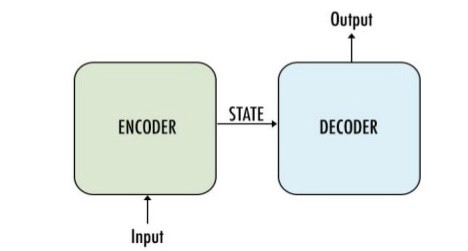

In [54]:
Image('s1.jpeg',width=600)

## 3.1 Encoder

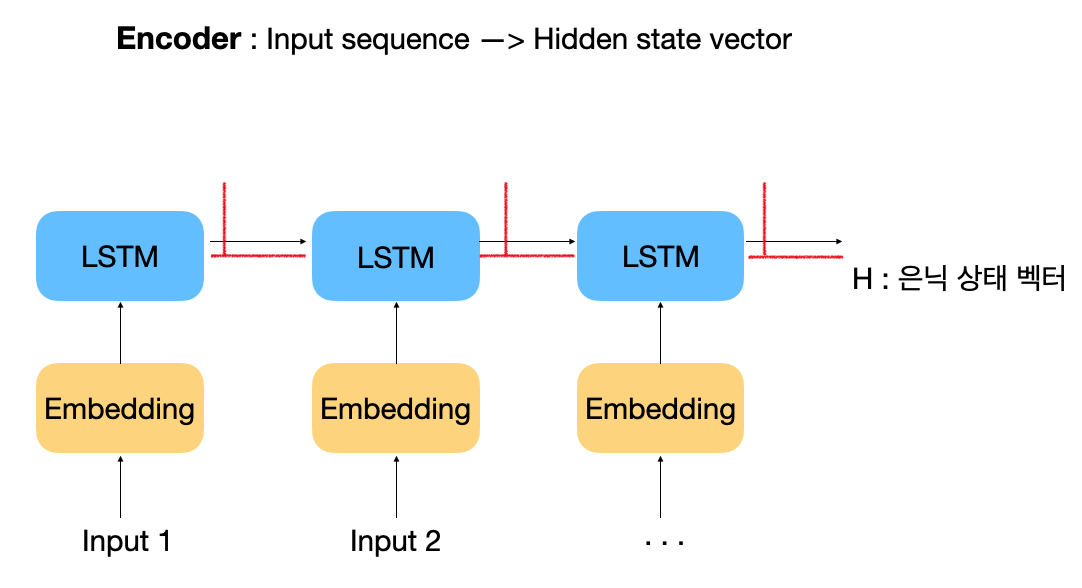

In [55]:
Image('e1.png',width=600)

In [23]:
encoder_inputs = Input(shape=(None,))
print(encoder_inputs)
enc_emb = Embedding(src_vocab_size, latent_dim)(encoder_input) # Embedding Layers, (4663, 50)(33000, 8)
print(enc_emb.shape)

Tensor("input_1:0", shape=(None, None), dtype=float32)
(33000, 8, 50)


아래의 **마스킹을 통하여** 위의 1.3에서 패딩된 자료에 대하여, 값이 0인 부분은 연산에서 제외시킨다.

In [ ]:
enc_masking = Masking(mask_value=0.0)(enc_emb) # Masking
encoder_lstm = LSTM(latent_dim, return_state=True) # 상태 값 리턴

encoder_output, state_h, state_c = encoder_lstm(enc_masking)

encoder_states = [state_h, state_c] # 은닉 상태, 셀 상태 저장

## 3.2 Decoder 

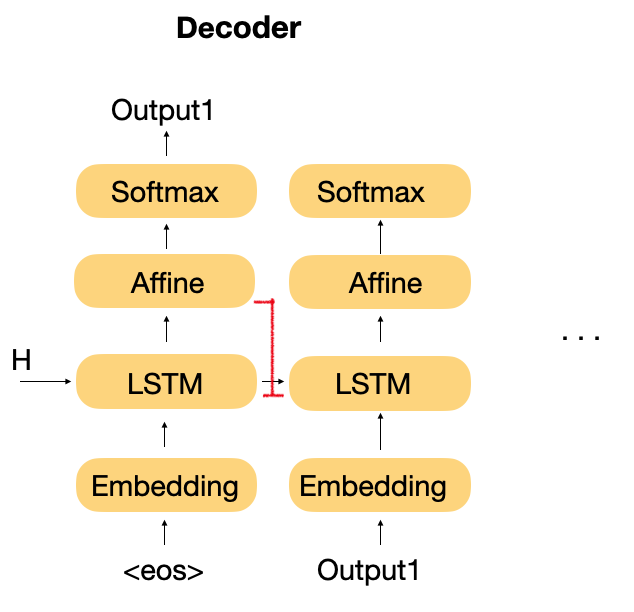

In [68]:
Image('d1.png',width=500)

In [28]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(src_vocab_size,latent_dim)
dec_emb = dec_emb_layer(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)

- return_state=True: 상태값 리턴  
- return_sequences=True: 모든 시점에서 단어를 예측


In [29]:
decoder_lstm = LSTM(latent_dim, return_sequences=True,return_state=True)

**중요**  
 
- 아래 코드에서, 인코더의 마지막 states 값들이 디코더의 초깃값으로 전달된다.

In [30]:
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=encoder_states)

모든 시점의 결과에서, 소프트맥스 함수를 사용하여 예측한 단어를 출력



In [31]:
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

## 3.3 모델 학습

모델 만들기

In [32]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

- 디코더는 각 시점에 대해 다중 클래스 분류 수행  ==> 소프트맥스 함수 ==> categorical crossentrophy
- 원핫인코딩됨 ==> categorical crossentrophy  
- 우리의 디코더 출력에서는 원핫인코딩 안됨 ==> 대안적으로 sparse_categorical_crossentropy 사용

In [33]:
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['acc'])

In [34]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     233150      input_2[0][0]                    
__________________________________________________________________________________________________
masking_1 (Masking)             (None, None, 50)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(33000, None, 50),  20200       masking_1[0][0]                  
_______________________________________________________________________________________

In [1]:
model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, epochs = 50)

NameError: ignored

# 3. seq2seq 기계 번역 수행하기  
  
seq2seq는 훈련 과정과 테스트 과정에서 동작 방식이 다르다. 따라서 테스트를 위해 모델을 다시 설계해주어야 한다.

In [2]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

NameError: ignored

In [ ]:
# 디코더
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2= dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

디코더 정의

In [3]:
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

NameError: ignored

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

         # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

References  
[1]https://wikidocs.net/86900